In [1]:
import torch; torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from function.VAE import VAE
from function.Dir import Dir
from function.Dataset import ImageDataset
from function.Loss import Custom_criterion
from function.Log import log

NUM_TO_LEARN = 5000
BATCH_SIZE = 32
EPOCHS = 5
LATENTDIM = 128
LEARN_RATE = 5e-4

DEVICE = 'cuda'
LOSS_PLOT = []
EPOCH_PLOT = []
LR_PLOT = []

In [2]:
name = f'{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn'
dataset = ImageDataset(NUM_TO_LEARN, 0) # 0代表使用STED_HC文件训练，1代表使用STED文件训练
dataloader = DataLoader(dataset, BATCH_SIZE, True)
vae = VAE(LATENTDIM).to(DEVICE)
vae = nn.DataParallel(vae)
criterion = Custom_criterion(mse_weight=1.0, ssim_weight=0.2, psnr_weight=0.5).cuda()
optimizer = torch.optim.AdamW(vae.parameters(), lr = LEARN_RATE)

In [3]:
def train(dataloader, criterion, optimizer, num_epochs):
    with open('training.log', 'w') as nothing: # 清空原log
        pass
    for epoch in range(num_epochs):
        vae.train() # 切换成训练模式
        total_loss = 0.0
        for i, (img_LR, img_HR) in enumerate(dataloader):
            img_LR = torch.squeeze(img_LR,dim = 1).to(DEVICE)
            img_HR = torch.squeeze(img_HR,dim = 1).to(DEVICE)
            img_SR, mu, logvar = vae(img_LR)
            img_SR = img_SR.to(DEVICE)
            # 这步为止，img_LR,img_HR,img_SR均是[batchsize,不知道是什么,宽，高]
            loss = criterion(img_SR, img_HR) # 每个BATCH的loss，64张图平均
            optimizer.zero_grad()
            loss.backward() # 最耗算力的一步
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader) # 每个EPOCH的loss，全部数据集的平均
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}")
        log(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}")

        LOSS_PLOT.append(total_loss)
        EPOCH_PLOT.append(epoch)
        if epoch % 300 == 0:
            torch.save(vae.state_dict(), Dir.TEMP()+'/checkpoint.pth')

In [4]:
print(DEVICE)
print('start!')
train(dataloader, criterion, optimizer, EPOCHS)
print('succsessfully done!')

cuda
start!
Epoch [1/5], Average Loss: 0.217034
Epoch [2/5], Average Loss: 0.189752
Epoch [3/5], Average Loss: 0.183278
Epoch [4/5], Average Loss: 0.153087
Epoch [5/5], Average Loss: 0.128663
succsessfully done!


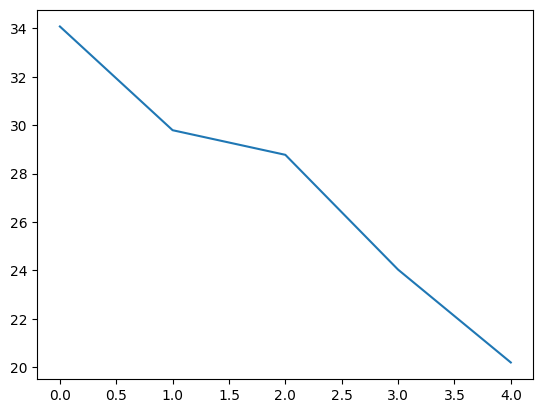

In [5]:
fig,ax = plt.subplots()
ax.plot(EPOCH_PLOT,LOSS_PLOT)
# plt.show() # jupyter不show也显示图片
fig.savefig(f'{Dir.models()}/lossfig_{name}.png', dpi = 300)

LOSS_DATA = np.stack((np.array(EPOCH_PLOT),np.array(LOSS_PLOT)),axis=0)
np.save(f'{Dir.models()}/lossdata_{name}.npy',LOSS_DATA)

torch.save(vae.state_dict(), f'{Dir.models()}/model_{name}.pth')